# CCTA Dataset Creation: HU Subdivision

## 1. Create dataframes collecting the coronary ostia's world coordinates

---

In [ ]:
%cd ../

/home/marco/contrast-gan-3D


In [ ]:
from contrast_gan_3D.dataset import utils as dset_utils
from contrast_gan_3D.utils import geometry, logging_utils

logging_utils.set_project_loggers_level(level="DEBUG")

contrast_gan_3D.utils.io_utils: INFO -> DEBUG
contrast_gan_3D.dataset.utils: INFO -> DEBUG
contrast_gan_3D.utils.geometry: INFO -> DEBUG


Adjust the variables in the following cell to match your setup. Run this code multiple times to process different datasets.

In [ ]:
from pathlib import Path
from pprint import pprint

DATASET_DIRS = [
    Path("/home/marco/data") / p
    for p in ["ASOCA_Philips/images", "MMWHS/ct_train", "MMWHS/ct_test"]
]

CENTERLINES_TOP_DIRS = [dir / "auto_centerlines" for dir in DATASET_DIRS]

# NOTE set to `None` if you don't want to write the dataframe to disk
OSTIA_DF_SAVENAMES = [dir / "ostia_world_coords.xlsx" for dir in DATASET_DIRS]

pprint(DATASET_DIRS)
pprint(CENTERLINES_TOP_DIRS)
pprint(OSTIA_DF_SAVENAMES)

[PosixPath('/home/marco/data/ASOCA_Philips/images'),
 PosixPath('/home/marco/data/MMWHS/ct_train'),
 PosixPath('/home/marco/data/MMWHS/ct_test')]
[PosixPath('/home/marco/data/ASOCA_Philips/images/auto_centerlines'),
 PosixPath('/home/marco/data/MMWHS/ct_train/auto_centerlines'),
 PosixPath('/home/marco/data/MMWHS/ct_test/auto_centerlines')]
[PosixPath('/home/marco/data/ASOCA_Philips/images/ostia_world_coords.xlsx'),
 PosixPath('/home/marco/data/MMWHS/ct_train/ostia_world_coords.xlsx'),
 PosixPath('/home/marco/data/MMWHS/ct_test/ostia_world_coords.xlsx')]


In [ ]:
for centerlines_dir, ostia_df_savename in zip(CENTERLINES_TOP_DIRS, OSTIA_DF_SAVENAMES):
    print(f"Centerlines: {str(centerlines_dir)!r} Ostias: {str(ostia_df_savename)!r}")

    ostia_paths = sorted(list(centerlines_dir.glob("*/ostia.xml")))

    ostia_dataframe = dset_utils.create_ostia_dataframe(
        ostia_paths, ostia_sheet_savename=ostia_df_savename
    )
    display(ostia_dataframe.head())

Centerlines: '/home/marco/data/ASOCA_Philips/images/auto_centerlines' Ostias: '/home/marco/data/ASOCA_Philips/images/ostia_world_coords.xlsx'
[2024-01-18 12:05:14,499: INFO] Total L/R ostia coordinates: (120, 3) (contrast_gan_3D.dataset.utils:22)
[2024-01-18 12:05:15,553: INFO] Saved ostia world coordinates to '/home/marco/data/ASOCA_Philips/images/ostia_world_coords.xlsx' (contrast_gan_3D.dataset.utils:35)


,id,x,y,z
0,ASOCA-000,212,211,-103
1,ASOCA-000,219,240,-93
2,ASOCA-001,177,260,-95
3,ASOCA-001,189,287,-83
4,ASOCA-002,189,229,-110


Centerlines: '/home/marco/data/MMWHS/ct_train/auto_centerlines' Ostias: '/home/marco/data/MMWHS/ct_train/ostia_world_coords.xlsx'
[2024-01-18 12:05:15,575: INFO] Total L/R ostia coordinates: (40, 3) (contrast_gan_3D.dataset.utils:22)
[2024-01-18 12:05:15,621: INFO] Saved ostia world coordinates to '/home/marco/data/MMWHS/ct_train/ostia_world_coords.xlsx' (contrast_gan_3D.dataset.utils:35)


,id,x,y,z
0,ct_train_1001_image,38,276,-179
1,ct_train_1001_image,44,306,-163
2,ct_train_1002_image,0,224,-141
3,ct_train_1002_image,19,246,-129
4,ct_train_1003_image,7,311,-166


Centerlines: '/home/marco/data/MMWHS/ct_test/auto_centerlines' Ostias: '/home/marco/data/MMWHS/ct_test/ostia_world_coords.xlsx'
[2024-01-18 12:05:15,654: INFO] Total L/R ostia coordinates: (80, 3) (contrast_gan_3D.dataset.utils:22)
[2024-01-18 12:05:15,690: INFO] Saved ostia world coordinates to '/home/marco/data/MMWHS/ct_test/ostia_world_coords.xlsx' (contrast_gan_3D.dataset.utils:35)


,id,x,y,z
0,ct_test_2001_image,-4,183,-105
1,ct_test_2001_image,9,206,-89
2,ct_test_2002_image,23,167,-104
3,ct_test_2002_image,12,142,-114
4,ct_test_2003_image,-5,230,-142


## 2. Divide the datapoints in optimal and suboptimal HU contrast values

CCTA scans are divided into *optimal* and *suboptimal* sets based on the contrast medium attenuation values at the 
aortic root. We fit a Mixture of Gaussians model on a 3D patch centered around the aortic root, and identify its 
attenuation value as the component with the highest mean HU value.

This data processing approach is described in 
"[Generative Adversarial Networks for Coronary CT Angiography Acquisition Protocol Correction with Explicit Attenuation Constraints (Van Herten, 2023)](https://openreview.net/pdf?id=MIHF_buWGUQ)"; the following code implementation is adapted from the first author's original codebase.

---

Adjust the variables in the following cell to match your setup:

In [ ]:
DATASET_NAMES = ["ASOCA", "MMWHS", "MMWHS"]
OSTIA_DATASET_PATH = Path("/home/marco/data/ostia_world_coords.xlsx")

print(DATASET_NAMES)
print(OSTIA_DATASET_PATH)

['ASOCA', 'MMWHS', 'MMWHS']
/home/marco/data/ostia_world_coords.xlsx


In [ ]:
import pandas as pd

if not OSTIA_DATASET_PATH.is_file():
    df = pd.concat(
        [
            pd.read_excel(path).assign(dataset=dataset_name)
            for path, dataset_name in zip(OSTIA_DF_SAVENAMES, DATASET_NAMES)
        ]
    )
    df.to_excel(OSTIA_DATASET_PATH, index=False)
    print("Saved ostia dataset")
else:
    df = pd.read_excel(OSTIA_DATASET_PATH)
    print("Loaded ostia dataset")

df

Loaded ostia dataset


,id,x,y,z,dataset
0,ASOCA-000,212,211,-103,ASOCA
1,ASOCA-000,219,240,-93,ASOCA
2,ASOCA-001,177,260,-95,ASOCA
3,ASOCA-001,189,287,-83,ASOCA
4,ASOCA-002,189,229,-110,ASOCA
...,...,...,...,...,...
235,ct_test_2038_image,14,214,-174,MMWHS
236,ct_test_2039_image,-4,110,-115,MMWHS
237,ct_test_2039_image,8,142,-105,MMWHS
238,ct_test_2040_image,16,303,-126,MMWHS


In [ ]:
(
    cadrads_path,
    cadrads_df,
) = "/home/marco/data/IDR_CADRADS/image/image3106/3106.h5", pd.read_excel(
    "/home/marco/data/IDR_CADRADS/ostia.xlsx"
)
asoca_path = "/home/marco/data/ASOCA_Philips/images/ASOCA-040.h5"
mmwhs_path = "/home/marco/data/MMWHS/ct_train/ct_train_1007_image.h5"

In [ ]:
from contrast_gan_3D.utils import io_utils

img_cad, meta_cad, f = io_utils.load_h5_image(cadrads_path, is_cadrads=True)
img_cad = img_cad[::]
print("CADRADS:", img_cad.dtype)
f.close()

img_asoca, meta_asoca, f = io_utils.load_h5_image(asoca_path)
img_asoca = img_asoca[::]
print("ASOCA:", img_asoca.dtype)
f.close()

img_mmwhs, meta_mmwhs, f = io_utils.load_h5_image(mmwhs_path)
img_mmwhs = img_mmwhs[::]
print("MMWHS", img_mmwhs.dtype)
f.close()

CADRADS: int16
ASOCA: int16
MMWHS int16


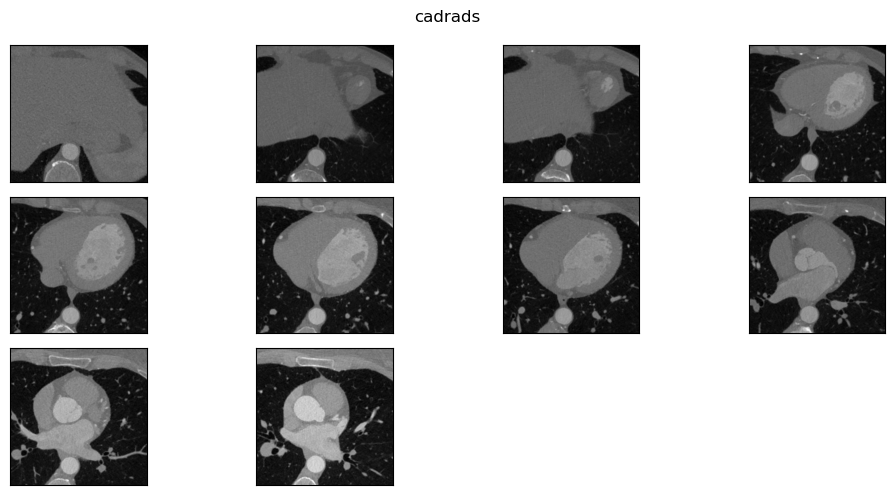

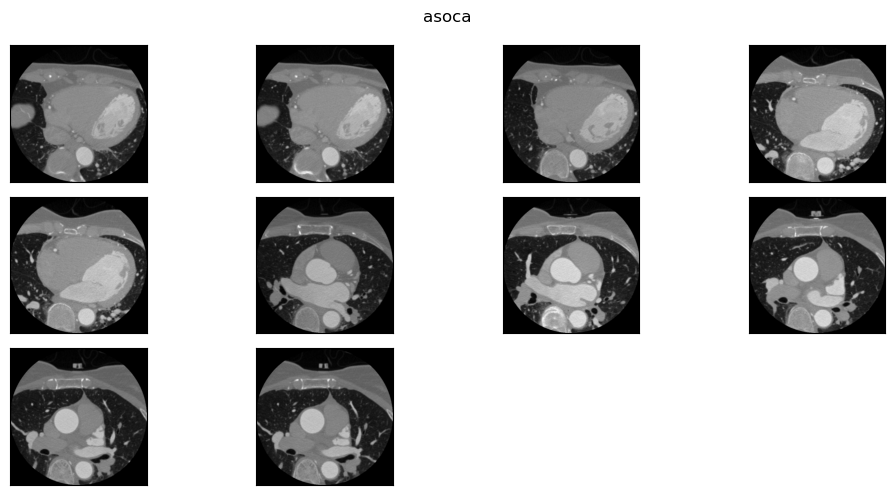

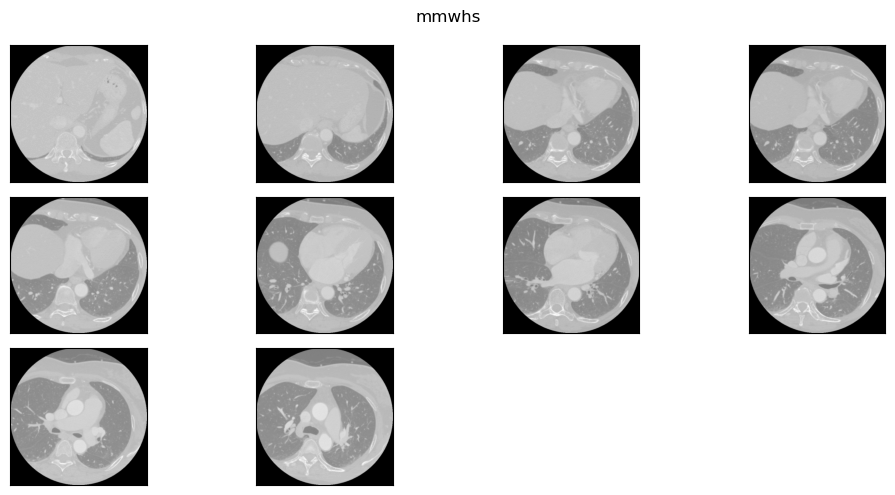

In [ ]:
import numpy as np

from contrast_gan_3D.utils import visualization

rng = np.random.default_rng()

for title, img in zip(["cadrads", "asoca", "mmwhs"], [img_cad, img_asoca, img_mmwhs]):
    ids = sorted(rng.choice(img.shape[-1], 10))
    visualization.plot_axial_slices(img[..., ids], title=title, figsize=(10, 5))

In [ ]:
l_cadrads, r_cadrads = geometry.extract_ostia_patch_3D(
    cadrads_path, cadrads_df, is_cadrads=True
)

l_asoca, r_asoca = geometry.extract_ostia_patch_3D(asoca_path, df)

l_mmwhs, r_mmwhs = geometry.extract_ostia_patch_3D(mmwhs_path, df)

[2024-01-18 12:05:26,491: DEBUG] Loaded '/home/marco/data/IDR_CADRADS/image/image3106/3106.h5' (contrast_gan_3D.utils.geometry:106)
[2024-01-18 12:05:27,353: DEBUG] Loaded '/home/marco/data/ASOCA_Philips/images/ASOCA-040.h5' (contrast_gan_3D.utils.geometry:106)
[2024-01-18 12:05:27,424: INFO] Subtracted 1024 to '/home/marco/data/ASOCA_Philips/images/ASOCA-040.h5' (contrast_gan_3D.utils.geometry:118)
[2024-01-18 12:05:28,149: DEBUG] Loaded '/home/marco/data/MMWHS/ct_train/ct_train_1007_image.h5' (contrast_gan_3D.utils.geometry:106)


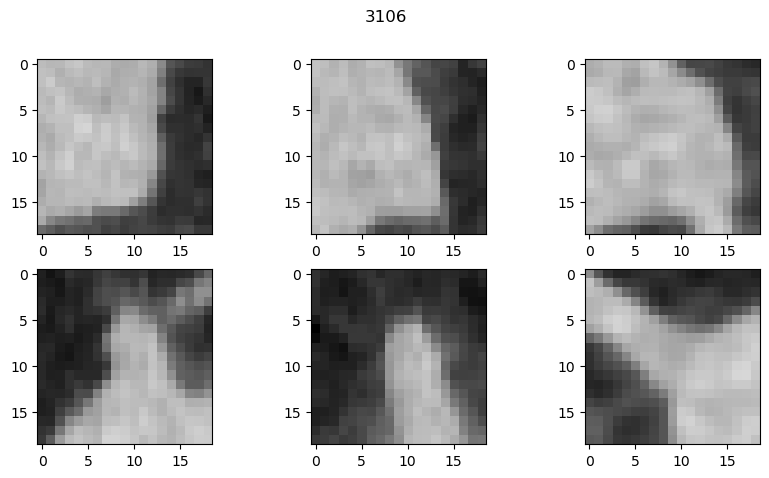

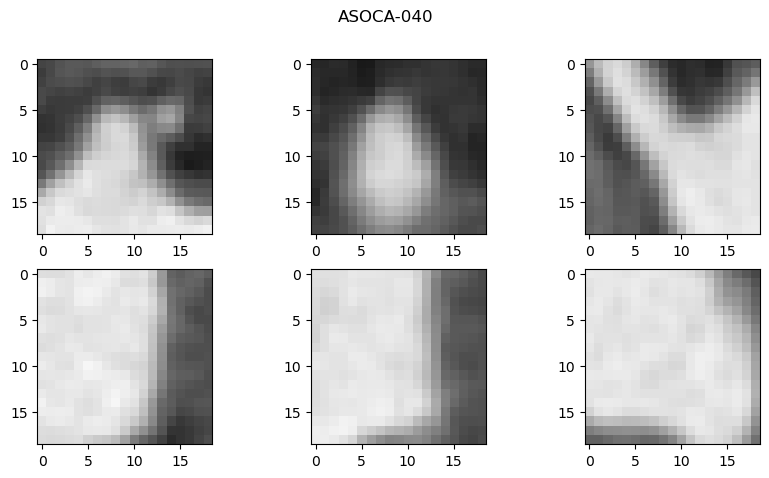

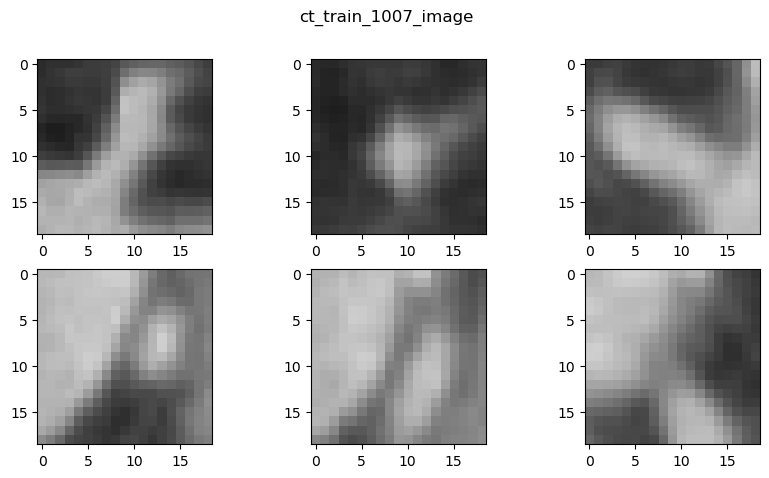

In [ ]:
visualization.plot_ostia_patch(
    np.stack([l_cadrads, r_cadrads]), title=io_utils.stem(cadrads_path)
)
visualization.plot_ostia_patch(
    np.stack([l_asoca, r_asoca]), title=io_utils.stem(asoca_path)
)
visualization.plot_ostia_patch(
    np.stack([l_mmwhs, r_mmwhs]), title=io_utils.stem(mmwhs_path)
);

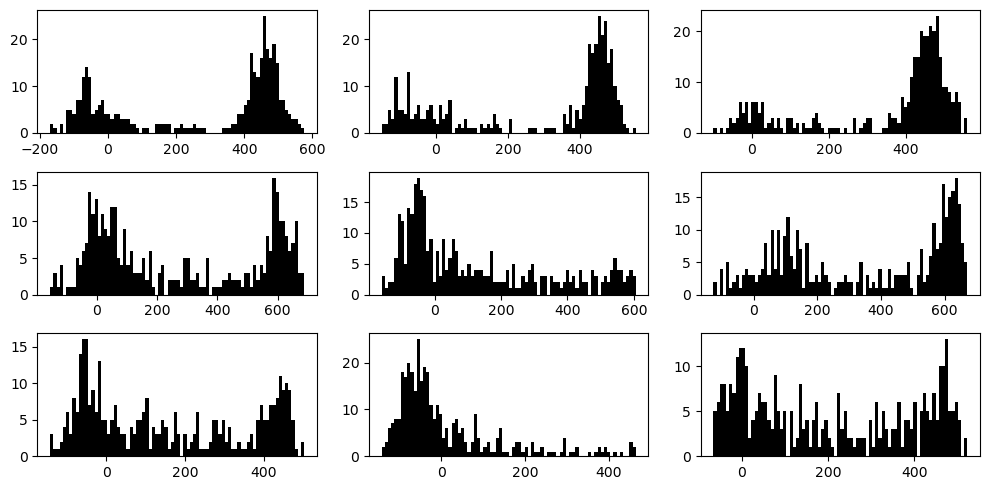

In [ ]:
visualization.plot_image_histogram(
    l_cadrads[len(l_cadrads) // 2, ...],
    l_cadrads[:, len(l_cadrads) // 2, :],
    l_cadrads[..., len(l_cadrads) // 2],

    l_asoca[len(l_asoca) // 2, ...],
    l_asoca[:, len(l_asoca) // 2, :],
    l_asoca[..., len(l_asoca) // 2],

    l_mmwhs[len(l_mmwhs) // 2, ...],
    l_mmwhs[:, len(l_mmwhs) // 2, :],
    l_mmwhs[..., len(l_mmwhs) // 2],

    tight=True,
);

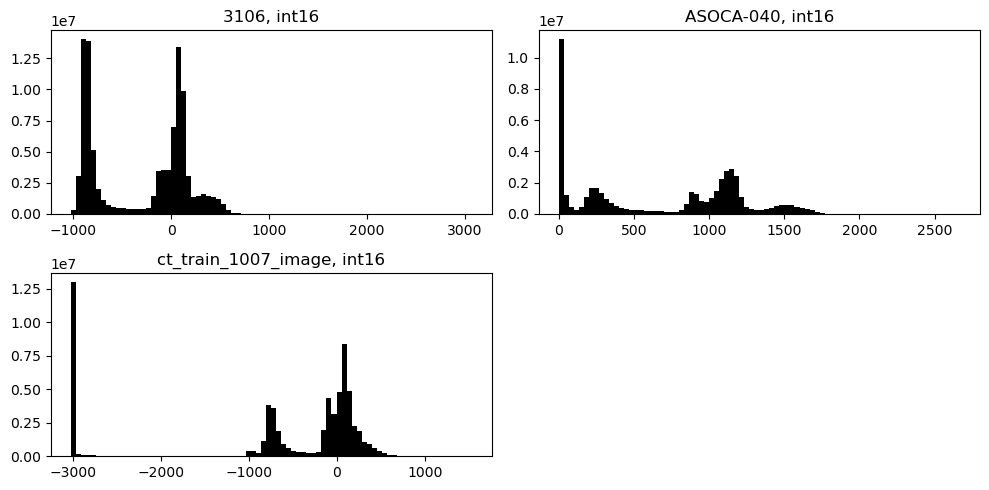

In [ ]:
visualization.plot_image_histogram(
    (img_cad, f"{io_utils.stem(cadrads_path)}, {img_cad.dtype}"),
    (img_asoca, f"{io_utils.stem(asoca_path)}, {img_asoca.dtype}"),
    (img_mmwhs, f"{io_utils.stem(mmwhs_path)}, {img_mmwhs.dtype}"),
    tight=True,
);